# SNR Threshold Finder Example

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from gwsnr.threshold import SNRThresholdFinder

file_name = '/Users/phurailatpamhemantakumar/phd/mypackages/semianalytic_pdet/injections.hdf'
# with h5py.File(file_name, 'r') as obj:
#     attrs = dict(obj.attrs.items())
#     events = obj['events'][:]

# mass1_detector = events['mass1_detector']
# mass2_detector = events['mass2_detector']
# mtot = mass1_detector + mass2_detector
# chirp_mass = (mass1_detector * mass2_detector)**(3/5) / (mtot)**(1/5)

# mass1_source = events['mass1_source']

# gstlal_far = events['gstlal_far']
# observed_snr_net = events['observed_snr_net']
# z = events['z']

test = SNRThresholdFinder(
    catalog_file = file_name,
    # below are all default values. You can omit them if you want. 
    # npool=4,
    # selection_range = dict(
    #     key_name = 'mtot',
    #     parameter = mtot, 
    #     range = (30, 60),
    # ),
    # original_detection_statistic = dict(
    #             key_name='gstlal_far',
    #             threshold=1,  # 1 per year
    #         ),
    # projected_detection_statistic = dict(
    #             key_name='observed_snr_net',
    #             threshold=None, # to be determined
    #             threshold_search_bounds=(6, 12),
    #         ),
    # parameters_to_fit = dict(
    #     key_name = ['z', 'mass1_source'],
    #     parameter=np.array([z,mass1_source]),
    # ),
    sample_size=20000,
    # multiprocessing_verbose=True,
)

In [14]:
best_thr, del_H, H, H_true, snr_thrs = test.find_threshold(iteration=10, print_output=True, no_multiprocessing=True)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.39s/it]

Best SNR threshold: 10.40


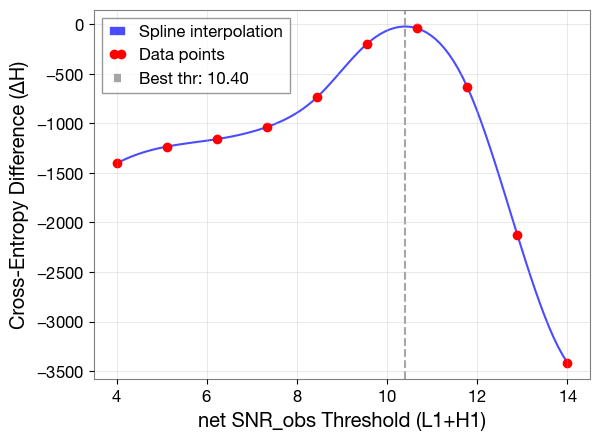

In [15]:
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt

spline = UnivariateSpline(snr_thrs, del_H, s=0)
snr_fine = np.linspace(snr_thrs.min(), snr_thrs.max(), 100)
del_H_fine = spline(snr_fine)
plt.plot(snr_fine, del_H_fine, 'b-', alpha=0.7, label='Spline interpolation')
plt.plot(snr_thrs, del_H, 'ro', markersize=6, label='Data points')
plt.axvline(best_thr, color='gray', linestyle='--', alpha=0.7, label=f'Best thr: {best_thr:.2f}')
plt.xlabel('net SNR_obs Threshold (L1+H1)')
plt.ylabel('Cross-Entropy Difference (ΔH)')
plt.grid(alpha=0.4) 
plt.legend()
plt.show()

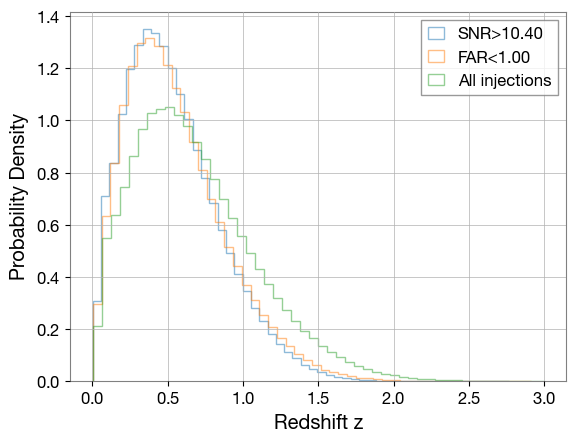

In [16]:
snr_th = best_thr
with h5py.File(file_name, 'r') as obj:
    attrs = dict(obj.attrs.items())
    events = obj['events'][:]

z = events['z']
observed_snr_net = events['observed_snr_net']
plt.hist(z[observed_snr_net>=snr_th], bins=50, density=True, alpha=0.5, color='C0', histtype='step', label=f'SNR>{best_thr:.2f}')
far_th = 1
gstlal_far = events['gstlal_far']
plt.hist(z[gstlal_far<far_th], bins=50, density=True, alpha=0.5, color='C1', histtype='step', label=f'FAR<{far_th:.2f}')
plt.hist(z, bins=50, density=True, alpha=0.5, color='C2', histtype='step', label='All injections')
plt.xlabel('Redshift z')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [17]:
# check rates
with h5py.File(file_name, 'r') as obj:
    attrs = dict(obj.attrs.items())
    events = obj['events'][:]

observed_snr_net = events['observed_snr_net']
gstlal_far = events['gstlal_far']

fraction_above_snr_thresh = np.sum(observed_snr_net >= best_thr) / len(observed_snr_net)
fraction_above_gstlal_far = np.sum(gstlal_far < 1) / len(observed_snr_net)

print(f"Fraction above SNR threshold {best_thr:.2f}: {fraction_above_snr_thresh:.6f}")
print(f"Fraction above GstLAL FAR threshold 1 per year: {fraction_above_gstlal_far:.6f}")


Fraction above SNR threshold 10.40: 0.522918
Fraction above GstLAL FAR threshold 1 per year: 0.286787


In [11]:
with h5py.File(file_name, 'r') as obj:
    attrs = dict(obj.attrs.items())
    events = obj['events'][:]

mass1_detector = events['mass1_detector']
mass2_detector = events['mass2_detector']
mtot = mass1_detector + mass2_detector
mtot.min(), mtot.max()

(2.0205733683046256, 1866.8677511428436)

In [21]:
cuts = np.linspace(6, 14, 10)
mass_points = np.geomspace(2, 500, 20)
mass_range = [[mass_points[i], mass_points[i+1]] for i in range(len(mass_points)-1)]

best_cuts = []

def objective(min_mass, max_mass,):
    
    test = SNRThresholdFinder(
        catalog_file = file_name,
        selection_range = dict(
            key_name = 'mtot',
            parameter = mtot, 
            range = (min_mass, max_mass),
        ),
    )

    best_thr, del_H, H, H_true, snr_thrs = test.find_threshold(iteration=10, print_output=True, no_multiprocessing=True)

    return best_thr

for mass_min, mass_max in mass_range:
    print(f"Mass range: {mass_min:.1f} - {mass_max:.1f}")

    best_cut = objective(mass_min, mass_max)

    best_cuts.append(best_cut)
best_cuts = np.array(best_cuts)

Mass range: 2.0 - 2.7
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.43it/s]


Best SNR threshold: 12.71
Mass range: 2.7 - 3.6
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]


Best SNR threshold: 11.30
Mass range: 3.6 - 4.8
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s]


Best SNR threshold: 12.16
Mass range: 4.8 - 6.4
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.95it/s]


Best SNR threshold: 11.77
Mass range: 6.4 - 8.6
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


Best SNR threshold: 11.51
Mass range: 8.6 - 11.4
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.36it/s]


Best SNR threshold: 10.47
Mass range: 11.4 - 15.3
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.87it/s]


Best SNR threshold: 11.22
Mass range: 15.3 - 20.4
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


Best SNR threshold: 10.68
Mass range: 20.4 - 27.3
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


Best SNR threshold: 11.16
Mass range: 27.3 - 36.6
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


Best SNR threshold: 11.14
Mass range: 36.6 - 48.9
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Best SNR threshold: 10.34
Mass range: 48.9 - 65.4
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.39s/it]


Best SNR threshold: 10.09
Mass range: 65.4 - 87.4
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.39s/it]


Best SNR threshold: 10.09
Mass range: 87.4 - 116.9
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]


Best SNR threshold: 10.02
Mass range: 116.9 - 156.4
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.39s/it]


Best SNR threshold: 9.82
Mass range: 156.4 - 209.1
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.40s/it]


Best SNR threshold: 10.01
Mass range: 209.1 - 279.6
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.39s/it]


Best SNR threshold: 9.98
Mass range: 279.6 - 373.9
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]


Best SNR threshold: 9.57
Mass range: 373.9 - 500.0
[WARNING] mtot not found in the catalog. Using the parameter array of the same name if provided.


100%|███████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]

Best SNR threshold: 10.22


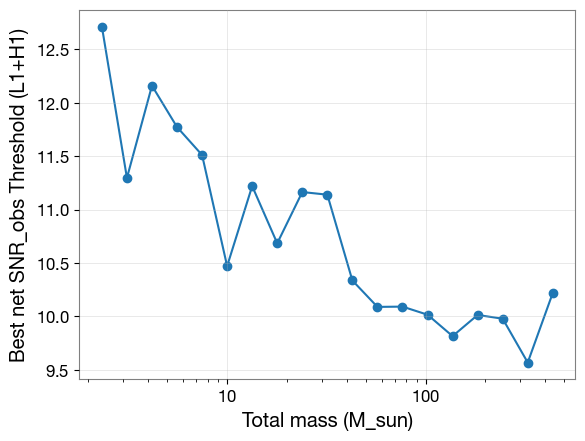

In [23]:
# plot mass vs best cuts
plt.plot([0.5*(mass_range[i][0]+mass_range[i][1]) for i in range(len(mass_range))], best_cuts, 'o-')
plt.xscale('log')
plt.xlabel('Total mass (M_sun)')
plt.ylabel('Best net SNR_obs Threshold (L1+H1)')
plt.grid(alpha=0.4)
plt.show()

In [24]:
with h5py.File(file_name, 'r') as obj:
    attrs = dict(obj.attrs.items())
    events = obj['events'][:]

mass1_source = events['mass1_source']
mass1_source.min(), mass1_source.max()

(1.0011182390093958, 992.5473451410022)

In [25]:
cuts = np.linspace(6, 14, 10)
mass_points = np.geomspace(1, 200, 20)
mass_range = [[mass_points[i], mass_points[i+1]] for i in range(len(mass_points)-1)]

best_cuts = []

def objective(min_mass, max_mass,):
    
    test = SNRThresholdFinder(
        catalog_file = file_name,
        selection_range = dict(
            key_name = 'mass1_source',
            range = (min_mass, max_mass),
        ),
    )

    best_thr, del_H, H, H_true, snr_thrs = test.find_threshold(iteration=10, print_output=True, no_multiprocessing=True)

    return best_thr

for mass_min, mass_max in mass_range:
    print(f"Mass range: {mass_min:.1f} - {mass_max:.1f}")

    best_cut = objective(mass_min, mass_max)

    best_cuts.append(best_cut)
best_cuts = np.array(best_cuts)

Mass range: 1.0 - 1.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.30it/s]


Best SNR threshold: 13.15
Mass range: 1.3 - 1.7


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


Best SNR threshold: 10.78
Mass range: 1.7 - 2.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


Best SNR threshold: 12.20
Mass range: 2.3 - 3.1


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.22it/s]


Best SNR threshold: 11.64
Mass range: 3.1 - 4.0


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Best SNR threshold: 11.33
Mass range: 4.0 - 5.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]


Best SNR threshold: 11.29
Mass range: 5.3 - 7.0


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


Best SNR threshold: 11.20
Mass range: 7.0 - 9.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.98it/s]


Best SNR threshold: 11.36
Mass range: 9.3 - 12.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


Best SNR threshold: 11.24
Mass range: 12.3 - 16.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


Best SNR threshold: 10.21
Mass range: 16.3 - 21.5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


Best SNR threshold: 10.12
Mass range: 21.5 - 28.4


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Best SNR threshold: 9.67
Mass range: 28.4 - 37.5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Best SNR threshold: 9.28
Mass range: 37.5 - 49.6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Best SNR threshold: 9.69
Mass range: 49.6 - 65.6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Best SNR threshold: 9.87
Mass range: 65.6 - 86.6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Best SNR threshold: 10.46
Mass range: 86.6 - 114.5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.40s/it]


Best SNR threshold: 11.15
Mass range: 114.5 - 151.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


Best SNR threshold: 12.01
Mass range: 151.3 - 200.0


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.94it/s]

Best SNR threshold: 12.70


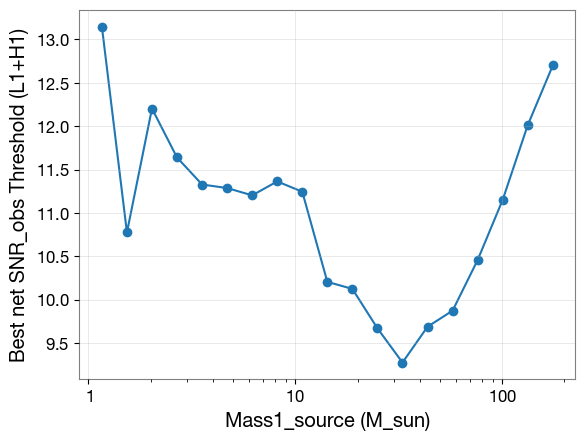

In [30]:
# plot mass vs best cuts
plt.plot([0.5*(mass_range[i][0]+mass_range[i][1]) for i in range(len(mass_range))], best_cuts, 'o-')
plt.xscale('log')
plt.xlabel('Mass1_source (M_sun)')
plt.ylabel('Best net SNR_obs Threshold (L1+H1)')
plt.grid(alpha=0.4)
plt.show()

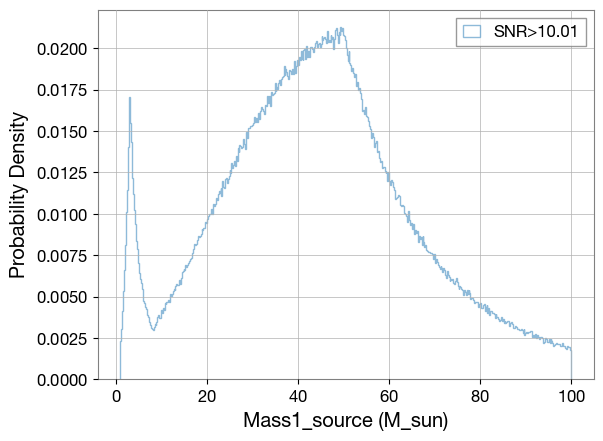

In [34]:
idx_ = (mass1_source>=1) & (mass1_source<=100)
plt.hist(mass1_source[idx_], bins=500, density=True, alpha=0.5, color='C0', histtype='step', label=f'SNR>{best_thr:.2f}')
plt.xlabel('Mass1_source (M_sun)')
plt.ylabel('Probability Density')
# plt.xlim(1, 60)
plt.legend()
plt.show()